In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('VCB.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
df

,Price
0,43216
1,44960
2,44429
3,44808
4,44505
...,...
1237,91700
1238,92600
1239,92800
1240,95000


In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10242.432, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10257.053, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10256.453, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10256.436, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10256.101, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10260.474, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10263.400, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10258.452, Time=1.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10258.432, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10262.432, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10262.427, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10257.670, Time=2.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=10240.858, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0]  

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val = model.predict(n_periods=len(y_val))

In [6]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[67259.00172206 67265.51380453 67265.38170213 67259.37339332
 67269.32045402 67258.80435361 67266.48591904 67263.98139026
 67260.73310855 67268.43636561 67258.94981499 67267.09316703
 67262.84978983 67262.0023439  67267.44333599 67259.3598252
 67267.3721262  67262.00193408 67263.12156611 67266.42430569
 67259.95571672 67267.37210708 67261.43241346 67264.05248638
 67265.44702955 67260.66333815 67267.14955283 67261.1198433
 67264.77611047 67264.56299378]


In [7]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 16272.419733364342
Testing RMSE: 12073.23560980849
Validation MAPE: 16.793007594253982
Testing MAPE: 13.9231236702878
Validation MAE: 14299.98019678583
Testing MAE: 11141.455487979601


Validation RMSE: 16272.419733364342
Testing RMSE: 12073.23560980849


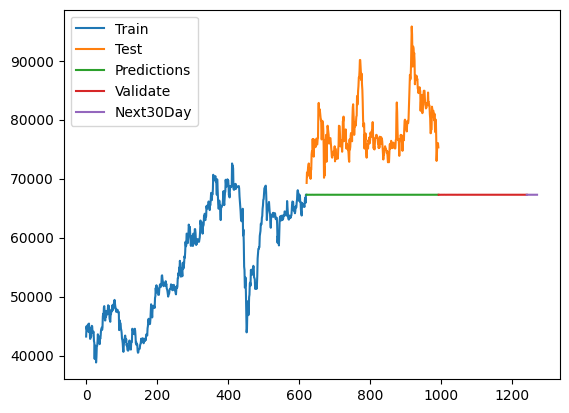

In [8]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()